In [1]:
from wfm.spherical_mesh import *
from timeit import timeit

In [2]:
2**(4*4*3) # possible vocab size

281474976710656

In [3]:
mesh = SphericalMesh()
type(mesh.points), mesh.points.shape, mesh.points.dtype

(numpy.ndarray, (100, 360, 180, 3), dtype('float32'))

In [4]:
torch_mesh = SphericalMesh(library = "torch")
type(torch_mesh.points), torch_mesh.points.shape, torch_mesh.points.dtype

(torch.Tensor, torch.Size([100, 360, 180, 3]), torch.float32)

In [5]:
jax_mesh = SphericalMesh(library = "jax")
type(jax_mesh.points), jax_mesh.points.shape, jax_mesh.points.dtype

(jaxlib.xla_extension.ArrayImpl, (100, 360, 180, 3), dtype('float32'))

In [6]:
timeit("""SphericalMesh(library = 'torch')""", number = 100, globals = {"SphericalMesh": SphericalMesh})

8.696012200089172

In [7]:
from wfm.input_processor import BinaryTokenizer, TextProcessor

[KeOps] Warning : No C++ compiler found. Define CXX environment variable or install g++.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : No C++ compiler found. You need to either define the CXX environment variable pointing to a valid compiler, or ensure that 'g++' is installed and in your PATH.
[KeOps] Warning : No C++ compiler available to check for OpenMP support.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [8]:
base_model = "utter-project/EuroLLM-1.7B-Instruct"
save_path = "../src/wfm/vocab_EuroLLM-1.7B-Instruct_windowsort_100.json"
tokenizer = BinaryTokenizer(base_tokenizer = base_model, base_embedder = base_model, load_from = save_path, use_svd = False, binary_dim = 16, cluster_size = 100, verbose = True)
text_processor = TextProcessor(tokenizer = tokenizer)

In [9]:
test_texts = [
    "The quick brown fox jumped over the lazy dog.",
    "Nel mezzo del cammin di nostra vita, mi ritrovai in una selva oscura",
    "Je sais pas quoi écrire"
]

encoded_input = tokenizer.encode(test_texts)
encoded_input.shape

(3, 16, 4, 4, 3)

In [10]:
tokenizer.decode(encoded_input)

['The quick brown fox jumped over the lazy dog.',
 'Nel mezzo del cammin di nostra vita, mi ritrovai in una selva oscura',
 'Je sais pas quoi écrire']

In [24]:
X = text_processor.process(test_texts)
X.shape

(3, 24, 4, 4, 3)

In [12]:
tokenizer.decode(X)

['<text>The quick brown fox jumped over the lazy dog.</text>',
 '<text>Nel mezzo del cammin di nostra vita, mi ritrovai in una selva oscura</text>',
 '<text>Je sais pas quoi écrire</text>']

In [13]:
type(X)

numpy.ndarray

In [14]:
from wfm.sensory_mapping import *

In [15]:
sfm_torch = SensoryFocusMatrixTorch(target_shape = (4, 4, 3), device = torch.device("cpu"))

In [16]:
X_with_peripheral = create_peripheral_array_simple(X)
print(f"Original shape: {X.shape}")
print(f"Transformed shape: {X_with_peripheral.shape}")

Original shape: (3, 24, 4, 4, 3)
Transformed shape: (3, 22, 12, 12, 3)


In [17]:
X_with_focus = sfm_torch(torch.as_tensor(X_with_peripheral))
X_with_focus.shape

torch.Size([3, 22, 12, 12, 3])

In [18]:
sm_torch = SurfaceMappingTorch(target_shape = (12, 12, 3), fourier_dim = 32, device = torch.device("cpu"))
X_fourier = sm_torch(X_with_focus)
X_fourier.shape

c:\Users\LENOVO\AppData\Local\pypoetry\Cache\virtualenvs\wfm-ErW5Bk3W-py3.12\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


torch.Size([3, 22, 3, 32, 2])

In [19]:
surface = torch_mesh.points
surface = surface[-1, ..., 1:]
surface.shape

torch.Size([360, 180, 2])

In [20]:
X_surface = fourier_transform(X_fourier, surface)
X_surface.shape

torch.Size([3, 22, 3, 360, 180])

Full text, split:  ['<s>', '▁<', 'text', '>', 'Nel', '▁mezzo', '▁del', '▁cammin', '▁di', '▁nostra', '▁vita', ',', '▁mi', '▁ritrov', 'ai', '▁in', '▁una', '▁selva', '▁oscura', '</', 'text', '>']


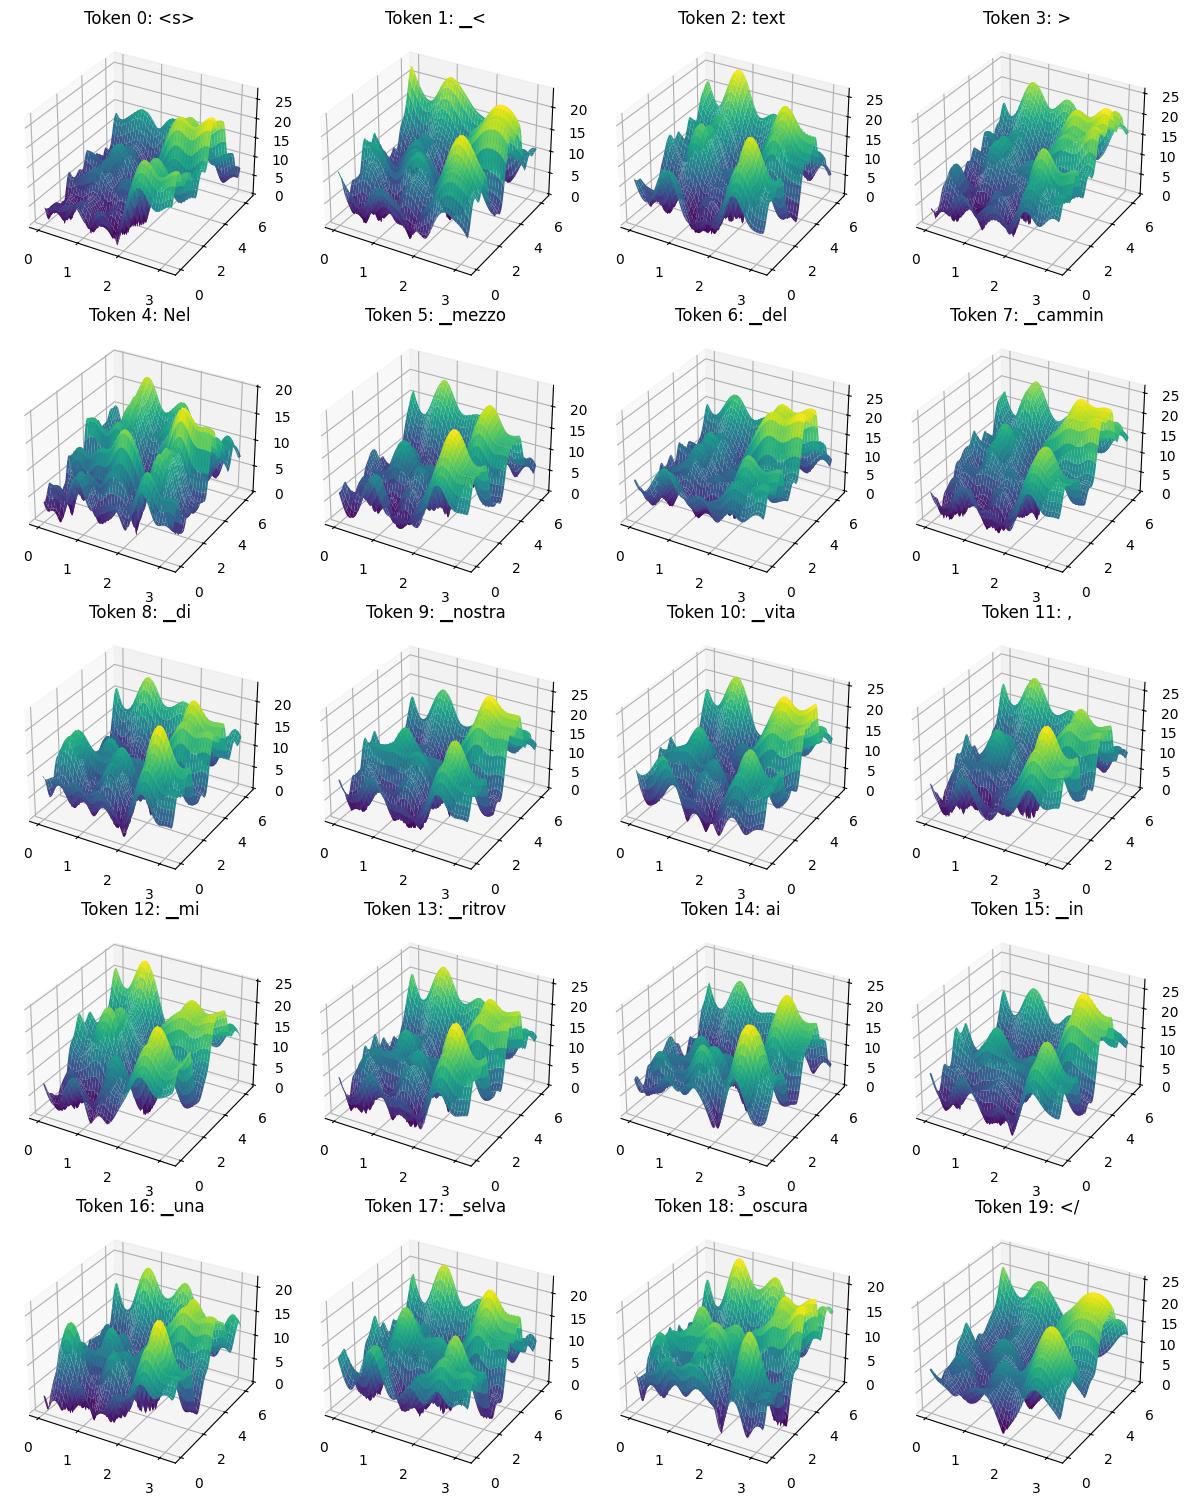

In [29]:
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('_mpl-gallery')

selected_input = 1
example = X_surface[selected_input, ...].detach().cpu().numpy()
tokens = text_processor.convert_ids_to_tokens(X[[selected_input], ...])[0][1:-1]
print("Full text, split: ", tokens)
n_rows = example.shape[0] // 4
f, ax = plt.subplots(n_rows, 4, figsize = (12, 3 * n_rows), subplot_kw={"projection": "3d"})
for i in range(n_rows):
    for j in range(4):
        theta, phi = np.meshgrid(np.linspace(0, np.pi, 180), np.linspace(0, 2*np.pi, 360))
        surface_field = example[i*4 + j, 1:]**(2)
        surface_field = np.sqrt(surface_field.sum(axis = 0))
        ax[i, j].plot_surface(theta, phi, surface_field, cmap = cm.viridis)
        ax[i, j].set_title(f"Token {i*4 + j}: {tokens[i*4 + j]}")
plt.tight_layout()